# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn import model_selection
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [2]:
df = pd.read_csv("age_of_mariage.csv")
df.sample(n=10)

,id,gender,height,religion,caste,mother_tongue,profession,location,country,age_of_marriage
330,331,female,"5'2""",Hindu,Ahom,Assamese,Not Specified,Delhi,India,27.0
269,270,male,"5'9""",Hindu,Agri,Marathi,Entrepreneurs / Business,Raigad,India,30.0
41,42,male,NaN,NaN,others,Telugu,Not Specified,Nizamabad,India,25.0
27,28,male,"5'10""",Hindu,Lingayath,Kannada,Software Professional,San Francisco- CA,USA,34.0
2199,2200,male,"5'7""",Hindu,Ahom,Assamese,Managers and Senior Executives,Jorhat,India,29.0
1723,1724,female,"5'4""",Hindu,Scheduled Caste (SC),Hindi,Team Member / Staff,Gurgaon,India,31.0
813,814,male,"5'11""",Sikh,Kshatriya,Punjabi,Doctor / Healthcare Professional,Ludhiana,India,30.0
2542,2543,male,"6'4""",NaN,others,Telugu,NaN,Middlesboro- KY,NaN,34.0
1047,1048,female,"5'6""",Sikh,Ramdasia,Punjabi,Not Specified,Chandigarh,India,31.0
276,277,male,"5'9""",NaN,others,Marathi,Electronics / Telecom Engineer,Nagpur,India,32.0


In [3]:
df.shape

(2567, 10)

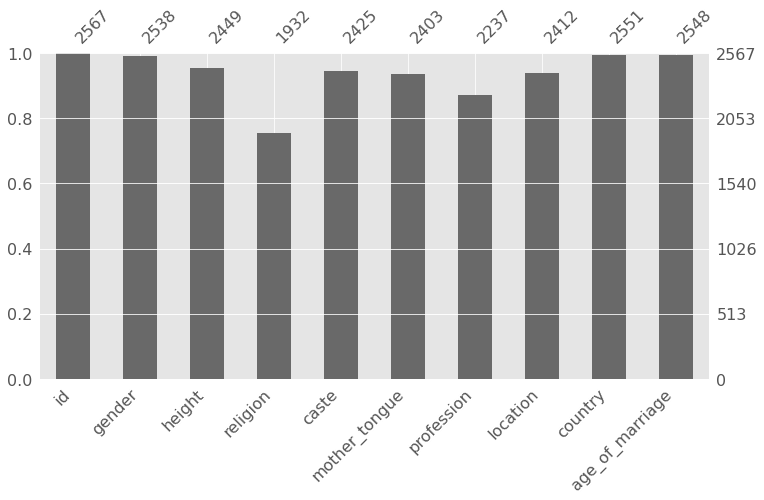

In [4]:
msno.bar(df, figsize=(12,6))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2567 entries, 0 to 2566
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2567 non-null   int64  
 1   gender           2538 non-null   object 
 2   height           2449 non-null   object 
 3   religion         1932 non-null   object 
 4   caste            2425 non-null   object 
 5   mother_tongue    2403 non-null   object 
 6   profession       2237 non-null   object 
 7   location         2412 non-null   object 
 8   country          2551 non-null   object 
 9   age_of_marriage  2548 non-null   float64
dtypes: float64(1), int64(1), object(8)
memory usage: 200.7+ KB


In [6]:
df.astype('object').describe().T

,count,unique,top,freq
id,2567,2567,1,1
gender,2538,2,male,1338
height,2449,28,"5'3""",229
religion,1932,5,Hindu,1576
caste,2425,42,others,493
mother_tongue,2403,27,Hindi,508
profession,2237,86,Not Specified,264
location,2412,536,Mumbai,213
country,2551,29,India,2246
age_of_marriage,2548.0,17.0,30.0,415.0


In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum().mul(100).div(len(df))

id                  0.000000
gender              1.129723
height              4.596806
religion           24.737047
caste               5.531749
mother_tongue       6.388781
profession         12.855473
location            6.038177
country             0.623296
age_of_marriage     0.740164
dtype: float64

In [9]:
df['height'][~df['height'].isna()] = (
    df['height'][~df['height'].isna()].str.replace('"', "")
    .str.split("'").apply(
        lambda x: int(x[0])*30.48 + int(x[1])*2.54
    ).astype(float)
)

df['height'] = pd.to_numeric(df.height, errors='coerce')

In [10]:
df.head()

,id,gender,height,religion,caste,mother_tongue,profession,location,country,age_of_marriage
0,1,female,162.56,NaN,others,Telugu,NaN,London,United Kingdom,21.0
1,2,male,170.18,Jain,Shwetamber,Gujarati,Doctor / Healthcare Professional,Fairfax- VA,USA,32.0
2,3,male,170.18,Hindu,Brahmin,Hindi,Entrepreneurs / Business,Begusarai,India,32.0
3,4,female,152.40,Hindu,Thakur,Hindi,Architect,Mumbai,India,30.0
4,5,male,165.10,Christian,Born Again,Malayalam,Sales Professional / Marketing,Sulthan Bathery,India,30.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2567 entries, 0 to 2566
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2567 non-null   int64  
 1   gender           2538 non-null   object 
 2   height           2449 non-null   float64
 3   religion         1932 non-null   object 
 4   caste            2425 non-null   object 
 5   mother_tongue    2403 non-null   object 
 6   profession       2237 non-null   object 
 7   location         2412 non-null   object 
 8   country          2551 non-null   object 
 9   age_of_marriage  2548 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 200.7+ KB


In [12]:
df.isna().sum()

id                   0
gender              29
height             118
religion           635
caste              142
mother_tongue      164
profession         330
location           155
country             16
age_of_marriage     19
dtype: int64

In [13]:
df[['height', 'age_of_marriage']].describe().T

,count,mean,std,min,25%,50%,75%,max
height,2449.0,164.352209,11.231685,134.62,157.48,165.1,172.72,213.36
age_of_marriage,2548.0,29.648352,2.802414,20.00,28.00,30.0,32.00,36.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49069a7910>,
      dtype=object)

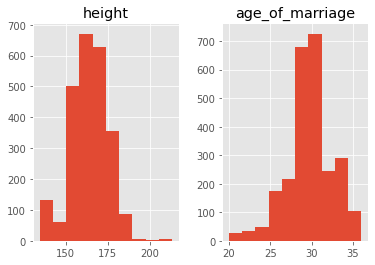

In [14]:
df[['height', 'age_of_marriage']].hist()

In [16]:
df.columns

Index(['id', 'gender', 'height', 'religion', 'caste', 'mother_tongue',
       'profession', 'location', 'country', 'age_of_marriage'],
      dtype='object')

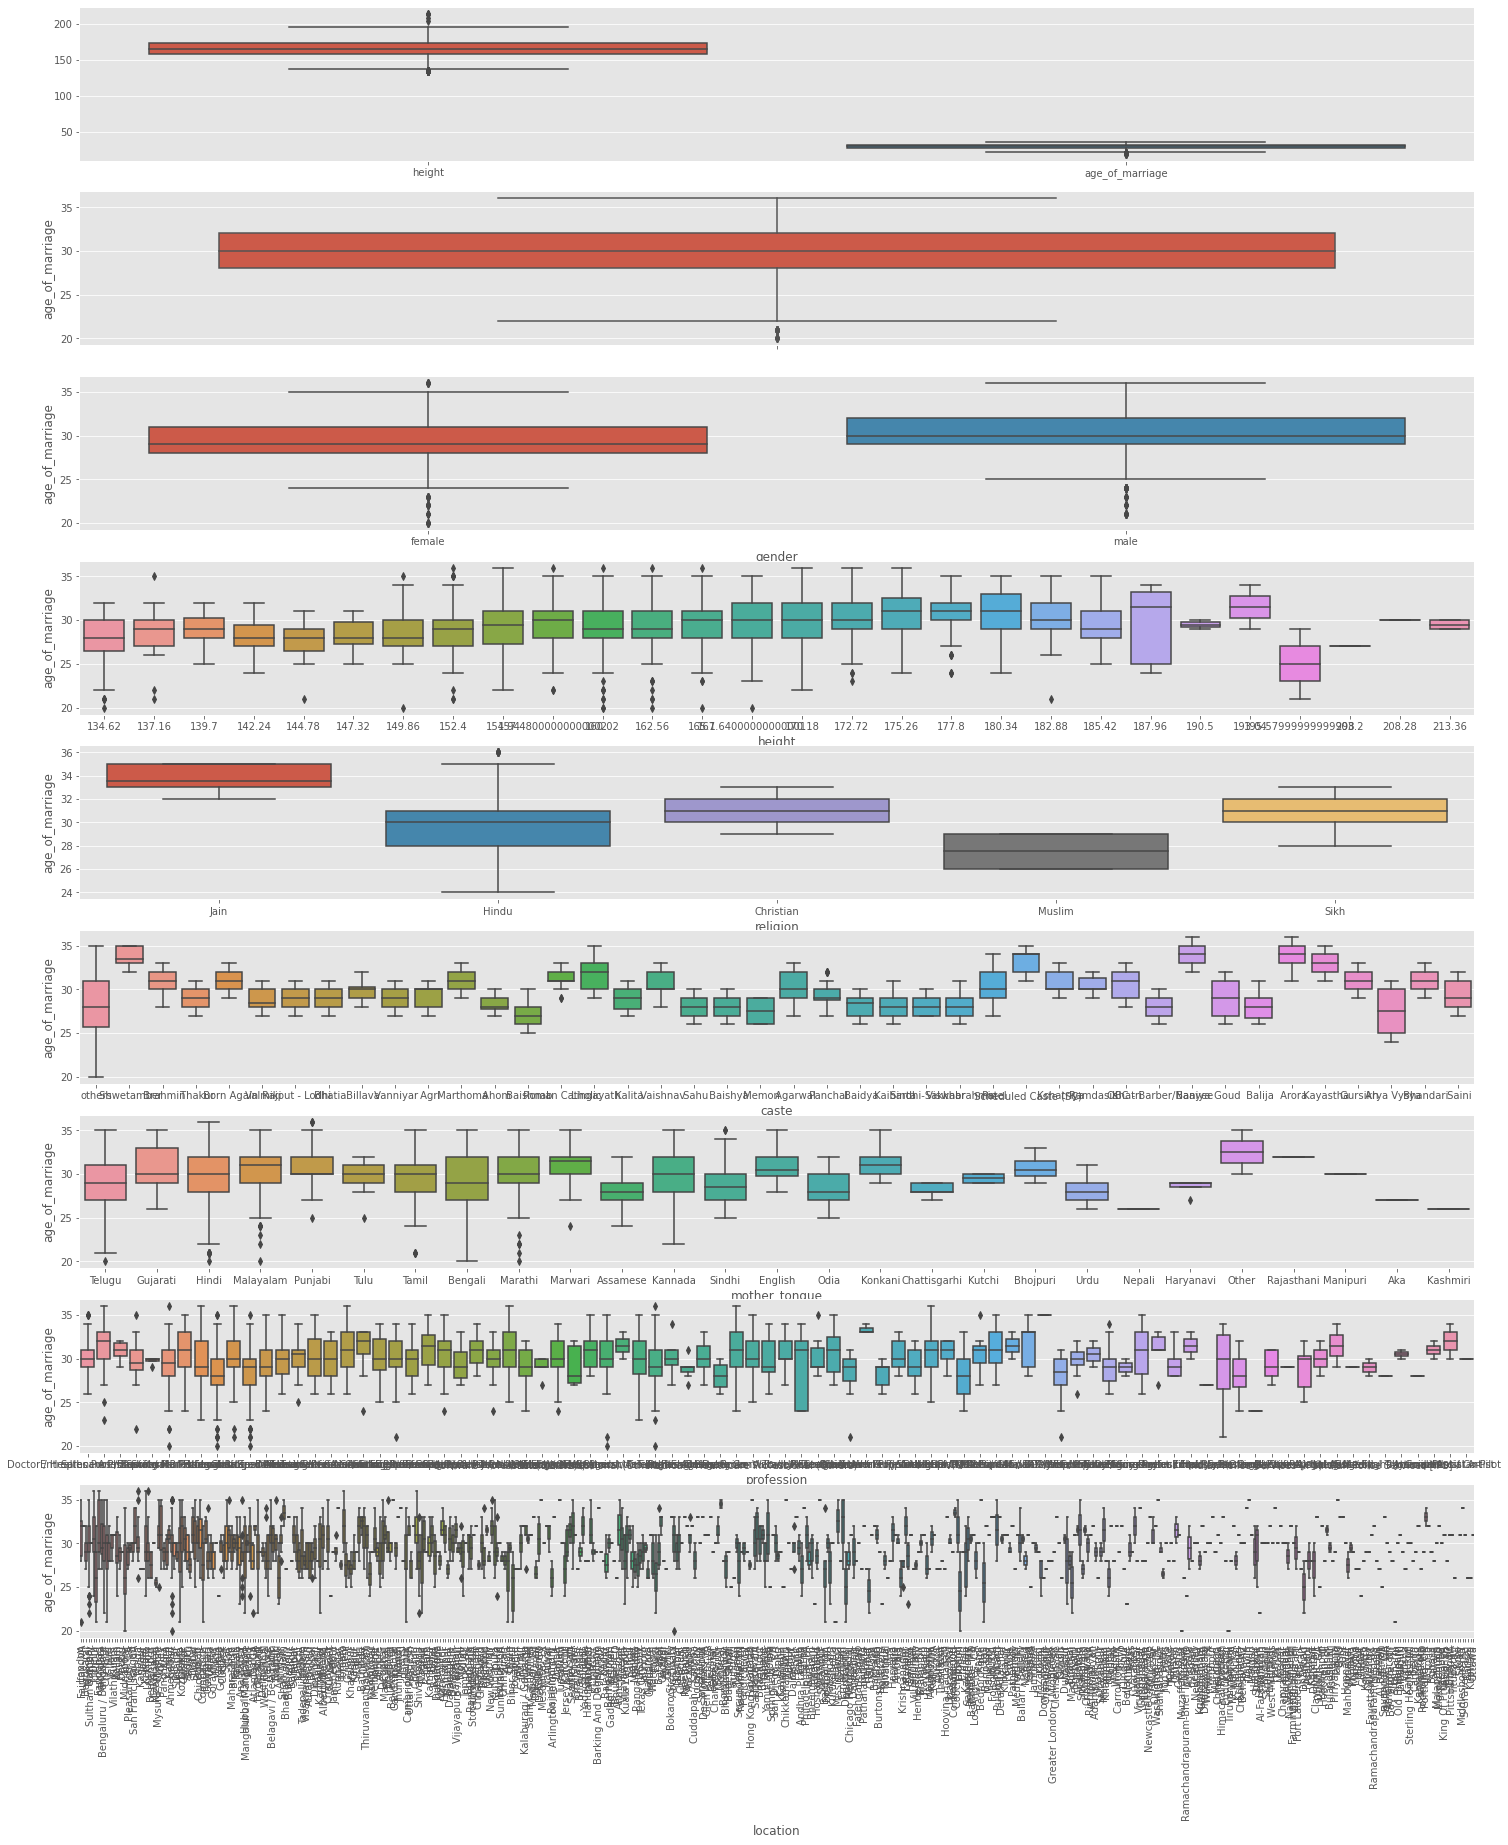

In [23]:
fig, axes = plt.subplots(nrows=9,ncols=1)
fig.set_size_inches(25, 30)
sns.boxplot(data=df.drop(columns=['id']),orient="v",ax=axes[0])
sns.boxplot(data=df,y="age_of_marriage",orient="v",ax=axes[1])
sns.boxplot(data=df,y="age_of_marriage",x="gender",orient="v",ax=axes[2])
sns.boxplot(data=df,y="age_of_marriage",x="height",orient="v",ax=axes[3])
sns.boxplot(data=df,y="age_of_marriage",x="religion",orient="v",ax=axes[4])
sns.boxplot(data=df,y="age_of_marriage",x="caste",orient="v",ax=axes[5])
plt.xticks(rotation=90)
sns.boxplot(data=df,y="age_of_marriage",x="mother_tongue",orient="v",ax=axes[6])
plt.xticks(rotation=90)
sns.boxplot(data=df,y="age_of_marriage",x="profession",orient="v",ax=axes[7])
plt.xticks(rotation=90)
sns.boxplot(data=df,y="age_of_marriage",x="location",orient="v",ax=axes[8])
plt.xticks(rotation=90)
plt.show();

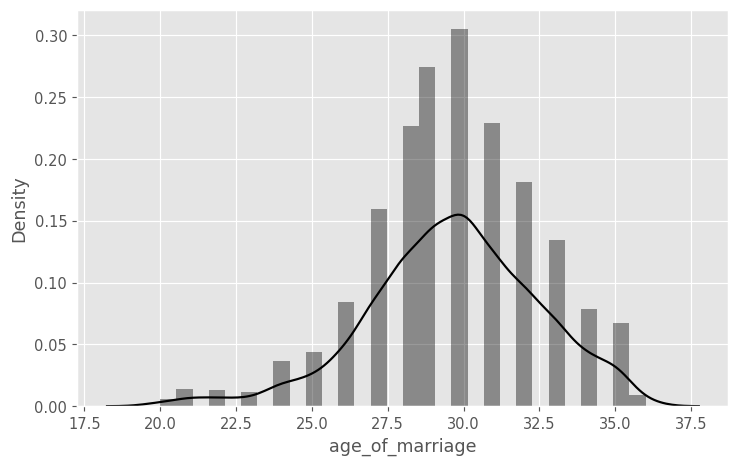

In [22]:
plt.figure(figsize=(8, 5), dpi=105)
sns.distplot(df['age_of_marriage'], color='k', bins=30, hist_kws={'alpha': 0.4});